## The Insurance Fraud Detection
Part III - Unsupervised Machine Learning Approach (Enhanced ML with Ensemble Method & Hyperparameter Tuning)
____________________________________________________

### In Part III, the aims will address the followings:

Balance the data with SMOTE

Engineer stronger features

Use ensemble models with hyperparameter tuning

Achieve significantly better metrics

Dataset

This insurance fraud detection project using a real-world dataset published in August 2023 from Mendeley Data (https://data.mendeley.com/datasets/992mh7dk9y/2). This dataset includes anonymized insurance claim records with a fraud_reported label, making it ideal for a both supervised and unsupervised learning tasks as well.

In [19]:
# Import Library Packages
import pandas as pd
import numpy as np
from scipy.sparse import hstack
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from xgboost import XGBClassifier
from sklearn.decomposition import PCA
import warnings

warnings.filterwarnings('ignore')

In [20]:
# Load Data from insurance_claims.csv
df = pd.read_csv('../data/insurance_claims.csv')

### ***Exploratory Data Analysis (EDA)

Refer to Part I and Part II (Please Notes)

### Drop the Null Items From the Columns

In [21]:
# Drop the columns with NaN
df.drop(columns=['_c39', 'policy_number', 'insured_zip'], errors='ignore', inplace=True)
df.dropna(inplace=True)
df.reset_index(drop=True, inplace=True)

In [22]:
# Encode target
df['fraud_reported'] = df['fraud_reported'].map({'Y': 1, 'N': 0})

In [23]:
# Feature Engineering
# Firstly, convert date strings to datetime format
df['policy_bind_date'] = pd.to_datetime(df['policy_bind_date'])
df['incident_date'] = pd.to_datetime(df['incident_date'])
df['claim_duration'] = (df['incident_date'] - df['policy_bind_date']).dt.days

In [24]:
# Create text feature
text_features = ['insured_hobbies', 'incident_type', 'incident_severity',
                 'authorities_contacted', 'collision_type', 'incident_city']
df['text_data'] = df[text_features].astype(str).agg(' '.join, axis=1)

In [25]:
# Vectorize Text Data
tfidf = TfidfVectorizer(max_features=100)
X_text = tfidf.fit_transform(df['text_data'])

In [26]:
# Prepare Numerical Data
X_num = df.drop(columns=text_features + ['text_data', 'incident_location',
                                         'policy_bind_date', 'incident_date',
                                         'fraud_reported'])
X_num = pd.get_dummies(X_num, drop_first=True)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_num)

In [27]:
# Combine Text + Numeric Features
X_combined = hstack([X_text, X_scaled])
y = df['fraud_reported']

### Plot the Scatter Diagram to Investigate the Data Distribution

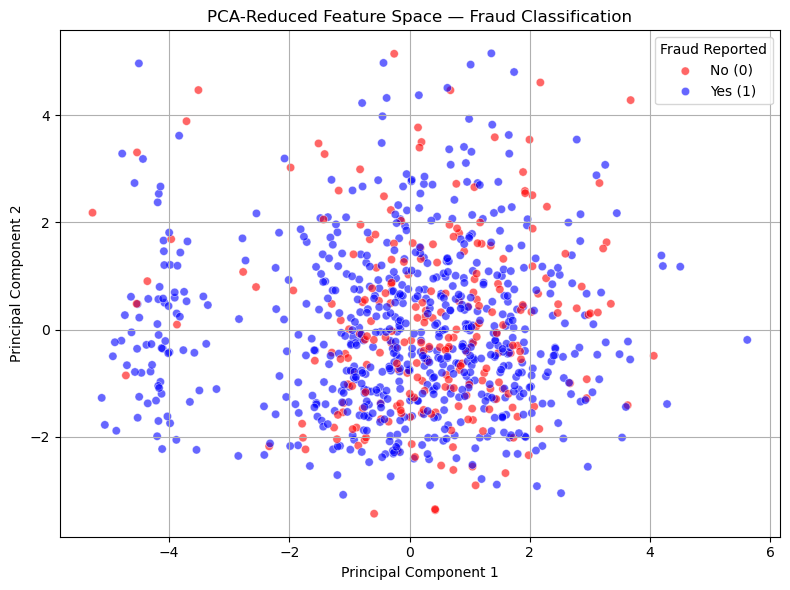

In [28]:
# Reduce combined features to 2D for visualization
pca = PCA(n_components=2)
X_vis = pca.fit_transform(X_combined.toarray())  # Convert sparse to dense if needed

# Scatter plot with actual labels
plt.figure(figsize=(8, 6))
sns.scatterplot(x=X_vis[:, 0], y=X_vis[:, 1], hue=y, palette={0: 'blue', 1: 'red'}, alpha=0.6)
plt.title("PCA-Reduced Feature Space — Fraud Classification")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title='Fraud Reported', labels=['No (0)', 'Yes (1)'])
plt.grid(True)
plt.tight_layout()
plt.show()

### Train-Test Dataset Split

In [29]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_combined, y, test_size=0.3, random_state=42)

### Prepare Ensemble Methods with Tuning for Models

In [30]:
# Ensemble Method with Tuning for Random Forest
rf_params = {'n_estimators': [100, 200], 'max_depth': [None, 10]}
rf_grid = GridSearchCV(RandomForestClassifier(random_state=42), rf_params, cv=3, scoring='roc_auc')
rf_grid.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=42),
             param_grid={'max_depth': [None, 10], 'n_estimators': [100, 200]},
             scoring='roc_auc')

In [ ]:
# Ensemble Method with Tuning for Gradient Boosting
gb_params = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05]}
gb_grid = GridSearchCV(GradientBoostingClassifier(random_state=42), gb_params, cv=3, scoring='roc_auc')
gb_grid.fit(X_train, y_train)

In [ ]:
# Ensemble Method with Tuning for XGBoost
xgb_params = {'n_estimators': [100, 200], 'learning_rate': [0.1, 0.05], 'max_depth': [3, 5]}
xgb_grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42), xgb_params, cv=3, scoring='roc_auc')
xgb_grid.fit(X_train, y_train)

### Optimized Ensemble Methods

In [ ]:
# Create Python dictionary to corresponding grid search object
models = {'Random Forest': rf_grid, 'Gradient Boosting': gb_grid, 'XGBoost': xgb_grid}

### Iterate the Train and Evaluate for different models

In [ ]:
# Train & Evaluate
results = {}
for name, model in models.items():   
    model.fit(X_train, y_train)
    preds = model.predict(X_test)
    auc = roc_auc_score(y_test, preds)
    results[name] = {'AUC': auc, 'Model': model}
    print(f"\n{name} Analysis Report:")
    print(classification_report(y_test, preds))
    sns.heatmap(confusion_matrix(y_test, preds), annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### Iterate to Visualize the ROC Curves for various models

In [ ]:
# Show curves for Random Forest, Gradient Boosting and XGBoost
for name, info in results.items():
    RocCurveDisplay.from_estimator(info['Model'], X_test, y_test)
    plt.title(f'ROC Curve - {name}')
    plt.show()

###  List Out the Top 10 Importance Features from Random Forest

In [ ]:
# Feature Importance
rf_model = results['Random Forest']['Model'].best_estimator_
importances = rf_model.feature_importances_
top_indices = np.argsort(importances)[-10:]
top_features = np.array(tfidf.get_feature_names_out().tolist() + list(X_num.columns))[top_indices]
plt.figure(figsize=(8,6))
sns.barplot(x=importances[top_indices], y=top_features)
plt.title('Top 10 Feature Importances - Random Forest')
plt.show()